# Install Libraries

In [1]:
!pip install pillow

# Download Dataset

In [2]:
DATASET_FILE = "scalene_triangle_0_355_step5_randomdisp_5000randomtest.zip"
DATASET_DIR = "scalene_triangle_0_355_step5_randomdisp_5000randomtest"
!rm -rf "$DATASET_DIR"
!curl -L https://github.com/joshbarrass/Y4ProjectNotebooks/raw/master/$DATASET_FILE > "$DATASET_FILE"
!unzip -d "$DATASET_DIR" "$DATASET_FILE" > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   188  100   188    0     0    964      0 --:--:-- --:--:-- --:--:--   969
100   199  100   199    0     0    718      0 --:--:-- --:--:-- --:--:--   718
100 19.6M  100 19.6M    0     0  22.9M      0 --:--:-- --:--:-- --:--:--  144M


# Define Helper Functions

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.spatial.transform import Rotation as R

D6_SHAPE = (3, 2)

def normalise(x):
    return x / np.linalg.norm(x)

def from_SO3_to_6D(SO3):
    """Convert an SO(3) rotation matrix to a 6D internal representation."""
    return SO3[:,:2]

def from_6D_to_SO3(D6):
    """Convert a 6D internal representation to an SO(3) rotation matrix."""
    b1 = normalise(D6[:,0])
    b2 = normalise(D6[:,1] - np.dot(b1, D6[:,1])*b1)
    b3 = np.cross(b1, b2)
    return np.array([b1, b2, b3]).T

def tf_6D_to_SO3(D6):
  """tensorflow-compatible conversion from 6D to SO(3). Used in the D6Convert layer."""
  a1 = D6[:,:,0]
  a2 = D6[:,:,1]
  b1 = tf.math.l2_normalize(a1, axis=-1)
  b2 = tf.math.l2_normalize(a2 - tf.reduce_sum(b1*a2)*b1, axis=-1)
  b3 = tf.linalg.cross(b1, b2)
  return tf.stack([b1, b2, b3], axis=2)

class D6Convert(layers.Layer):
  def call(self, inputs):
    target_input_shape = tf.TensorShape(((None,) + D6_SHAPE))
    if not inputs.shape.is_compatible_with(target_input_shape):
      raise TypeError("inputs to D6Convert should have shape {}, not {}".format(target_input_shape, inputs.shape))
    return tf_6D_to_SO3(inputs)

### DEPRECATED: Returns wrong value
# def SO3_distance(M1, M2):
#  """Returns the distance between two SO3 matrices in degrees"""
#  R = M1 * np.linalg.inv(M2)
#  return np.rad2deg(np.arccos((np.trace(R)-1)/2))

# Implement Quaternion SO(3) Distance

In [43]:
# quaternion [x, y, z, w]: w + xi + yj + zk
# this is the format outputted by scipy
def SO3_distance(M1, M2):
  """Returns the angle between two SO3 matrices in degrees.

  This is done by converting the matrices to quaternions and multiplying the
  conjugate of one with the other. The scalar part of the resulting quaternion
  is then cos(theta/2). The expression has been simplified to calculate only the
  scalar part."""
  x1, y1, z1, w1 = R.from_matrix(M1).as_quat()
  x2, y2, z2, w2 = R.from_matrix(M2).as_quat()
  angle = np.rad2deg(2*np.arccos(w1*w2 + x1*x2 + y1*y2 + z1*z2))
  # maximum rotation away from a given angle is 180 degrees
  # any further and you reduce the angle by rotating the opposite direction
  # some edge cases produce angles > 180 degrees, so rectify these
  if angle > 180:
    return 360 - angle
  return angle

### TEST SO3_distance
test_tolerance = 0.001
for i in range(100):
  test_angle1, test_angle2 = np.random.uniform(0, 180, 2) # max difference should be 180, as > 180 is no longer the shortest angle
  testM1 = R.from_euler("zyx", [test_angle1, 0, 0], degrees=True).as_matrix()
  testM2 = R.from_euler("zyx", [test_angle2, 0, 0], degrees=True).as_matrix()
  test_true_angle = abs(test_angle1-test_angle2)
  test_angle = abs(SO3_distance(testM1, testM2))
  assert test_angle + test_tolerance > test_true_angle and test_angle - test_tolerance < test_true_angle

In [5]:
SO31 = R.from_euler("zyx",[3, 2, 1]).as_matrix()
D61 = from_SO3_to_6D(SO31)
SO32 = R.from_euler("zyx",[0.5, 1, 1.2]).as_matrix()
D62 = from_SO3_to_6D(SO32)
print("True:", SO31, "\n", SO32, sep="")
print("np1:", from_6D_to_SO3(D61))
print("np2:", from_6D_to_SO3(D62))
print("tf:", tf_6D_to_SO3(np.array([D61, D62])))

True:[[ 0.41198225  0.05872664  0.90929743]
 [-0.68124272 -0.64287284  0.35017549]
 [ 0.60512725 -0.76371834 -0.2248451 ]]
[[ 0.47415988 -0.25903472  0.84147098]
 [ 0.86199739 -0.05800686 -0.50358287]
 [ 0.17925654  0.96412459  0.19578273]]
np1: [[ 0.41198225  0.05872664  0.90929743]
 [-0.68124272 -0.64287284  0.35017549]
 [ 0.60512725 -0.76371834 -0.2248451 ]]
np2: [[ 0.47415988 -0.25903472  0.84147098]
 [ 0.86199739 -0.05800686 -0.50358287]
 [ 0.17925654  0.96412459  0.19578273]]
tf: tf.Tensor(
[[[ 0.41198225  0.05872664  0.90929743]
  [-0.68124272 -0.64287284  0.35017549]
  [ 0.60512725 -0.76371834 -0.2248451 ]]

 [[ 0.47415988 -0.25903472  0.84147098]
  [ 0.86199739 -0.05800686 -0.50358287]
  [ 0.17925654  0.96412459  0.19578273]]], shape=(2, 3, 3), dtype=float64)


# Create Image Centering Function

In [6]:
import numpy as np
from scipy import ndimage
from PIL import Image
def centre_image(a: np.ndarray, target_centre=(0,0)):
  """Centres a single-channel image using centre of mass.
  
  Target centre is defined such that (x=0,y=0) is the centre of the image.
  Increasing x moves the centre to the right, increasing y moves the centre
  down."""
  if len(a.shape) == 2:
    a = a.reshape((1,) + a.shape)

  # determine all centres of mass
  # TODO: can potentially take advantage of labelling to remove "noise islands"
  if len(a.shape) == 3:
    COM = np.zeros((a.shape[0], 2))
    for i in range(a.shape[0]):
      COM[i] = ndimage.measurements.center_of_mass(a[i])
  else:
    raise TypeError("a should be either 2D image or an array of 2D")

  output = np.zeros(a.shape)

  # translate COM to centre of image
  for i in range(a.shape[0]):
    im = a[i]
    target_centre = (im.shape[0]/2 + target_centre[0],
                     im.shape[1]/2 + target_centre[1])
    # use affine transform with a=1, e=1, i=1, c=x, f=y to translate
    translation = (COM[i][0] - target_centre[0], COM[i][1] - target_centre[1])
    transform = np.array([[1, 0, translation[0]],
                          [0, 1, translation[1]],
                          [0, 0, 1]])
    output[i] = ndimage.affine_transform(im, transform, order=0)
  
  return output


# Load and Pre-Process Training Data

Dataset contains 360 images
Image shape is (32, 32, 1)
x will have shape (5760, 32, 32, 1)
y will have shape (5760, 3, 3)
Processing image files...


  0%|          | 0/360 [00:00<?, ?it/s]

Loading test data...


  0%|          | 0/4673 [00:00<?, ?it/s]

x_data has shape (5760, 32, 32, 1)
y_data has shape (5760, 3, 3)
x_test has shape (4673, 32, 32, 1)
y_test has shape (4673, 3, 3)
x_data values range from 0.0 to 1.0
[[-0.9396926  -0.34202015  0.        ]
 [ 0.34202015 -0.9396926   0.        ]
 [ 0.          0.          1.        ]]
(14.33214226053827, 15.236810931045653)


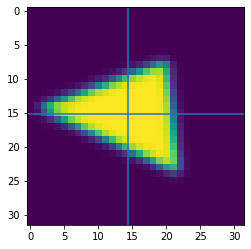

[[-0.97584056 -0.21848389  0.        ]
 [ 0.21848389 -0.97584056  0.        ]
 [ 0.          0.          1.        ]]
(16.35399290693408, 15.928775834658188)


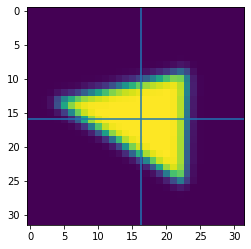

In [27]:
import os
import random
from scipy.spatial.transform import Rotation as R
from PIL import ImageFilter
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

def polar_to_cartesian(r, theta):
  r = np.abs(r)
  return r*np.cos(theta), r*np.sin(theta)

random.seed(0)

RESIZE_SHAPE = (32, 32) # (x, y)

GAUSS_RADIUS = 1 * RESIZE_SHAPE[0]/50
image_filter = ImageFilter.GaussianBlur(radius=GAUSS_RADIUS)

# displace the centre randomly
AUGMENT_CENTRE = True
CENTRE_AUGMENTATIONS = 16 if AUGMENT_CENTRE else 1
CENTRE_AUGMENTATION_SIGMA = 2 * RESIZE_SHAPE[0]/50

# dataset size increase factor due to augmentations
AUG_MULTIPLIER = 1 * CENTRE_AUGMENTATIONS

image_files = os.listdir(os.path.join(DATASET_DIR, "train"))
total_images = len(image_files)
print(f"Dataset contains {total_images} images")
if total_images == 0:
  raise ValueError("dataset has no images")

# image_shape = Image.open(os.path.join(DATASET_DIR, image_files[0])).size
image_shape = RESIZE_SHAPE + (1,)
print(f"Image shape is {image_shape}")
x_data = np.zeros((total_images*AUG_MULTIPLIER,) + image_shape, dtype="float32")
y_data = np.zeros((total_images*AUG_MULTIPLIER, 3, 3), dtype="float32")
print(f"x will have shape {x_data.shape}")
print(f"y will have shape {y_data.shape}")
print("Processing image files...")

def process_image(imf, augment_centre=False):
  """Takes a path to an image and loads it, performs pre-processing, and returns the xdata and ydata"""
  im = Image.open(imf).convert("L")
  im = im.resize(RESIZE_SHAPE)
  im = im.filter(image_filter) # blur early to simulate imperfect focus
  im = np.array(im).T # gives image with correct shape for centring
  angle = os.path.splitext(os.path.basename(imf))[0]
  if "_" in angle: # multiple examples; separate out the angle from the index
    angle = angle.split("_")[1]
  angle = float(angle)
  assert angle >= 0 and angle < 360
  rot_matrix = R.from_euler("zyx", (angle, 0, 0), True).as_matrix()
  
  # return now if no augmentations needed
  if not augment_centre: # and not ...
    return centre_image(im).reshape(image_shape)/255., rot_matrix
  
  # construct larger arrays for multiple images
  ims = np.empty((AUG_MULTIPLIER, ) + image_shape)
  rot_matrices = np.zeros((AUG_MULTIPLIER, 3, 3), dtype=rot_matrix.dtype)
  rot_matrices[:] = rot_matrix

  if augment_centre:
    for i in range(CENTRE_AUGMENTATIONS):
      r = np.random.normal(loc=0, scale=CENTRE_AUGMENTATION_SIGMA)
      #r = np.random.uniform(low=-CENTRE_AUGMENTATION_SIGMA, high=CENTRE_AUGMENTATION_SIGMA)
      theta = np.random.uniform(low=0, high=2*np.pi)
      ims[i] = centre_image(im, polar_to_cartesian(r, theta)).reshape(image_shape)/255.  
  
  return ims, rot_matrices

# load training data
for i, imf in tqdm(enumerate(image_files), total=total_images):
  if AUG_MULTIPLIER == 1:
    x_data[i,:,:], y_data[i,:,:] = process_image(os.path.join(DATASET_DIR, "train", imf))
  else:
    n = AUG_MULTIPLIER # alias
    x_data[i*n:i*n+n,:,:], y_data[i*n:i*n+n,:,:] = process_image(
        os.path.join(DATASET_DIR, "train", imf),
        augment_centre=AUGMENT_CENTRE,
    )

test_image_files = os.listdir(os.path.join(DATASET_DIR, "test"))
total_test_images = len(test_image_files)
x_test = np.zeros((total_test_images,) + x_data.shape[1:])
y_test = np.zeros((total_test_images,) + y_data.shape[1:])
print("Loading test data...")
for i, imf in tqdm(enumerate(test_image_files), total=total_test_images):
  x_test[i,:,:], y_test[i,:,:] = process_image(os.path.join(DATASET_DIR, "test", imf))

print(f"x_data has shape {x_data.shape}")
print(f"y_data has shape {y_data.shape}")
print(f"x_test has shape {x_test.shape}")
print(f"y_test has shape {y_test.shape}")

print(f"x_data values range from {np.min(x_data)} to {np.max(x_data)}")

im0 = x_data[0,:,:].reshape(RESIZE_SHAPE).T
rot0 = y_data[0]
plt.imshow(im0)
COM = ndimage.measurements.center_of_mass(im0.T)
plt.axvline(COM[0])
plt.axhline(COM[1])
print(rot0)
print(COM)
plt.show()

im1 = x_test[1,:,:].reshape(RESIZE_SHAPE).T
rot1 = y_test[1]
plt.imshow(im1)
COM = ndimage.measurements.center_of_mass(im1.T)
plt.axvline(COM[0])
plt.axhline(COM[1])
print(rot1)
print(COM)
plt.show()


# Construct Network

In [28]:
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 16
epochs = 100

model = keras.Sequential([
                          layers.InputLayer(input_shape=image_shape),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPool2D(pool_size=2, strides=2),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPool2D(pool_size=2, strides=2),
                          layers.Flatten(),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(256, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(np.prod(D6_SHAPE), activation="tanh"),
                          layers.Reshape(D6_SHAPE),
                          D6Convert(),
])
model.summary()
# possible new optimizer: keras.optimizers.SGD(learning_rate=0.007, momentum=0.1)
model.compile(optimizer="sgd", loss="mean_squared_error", metrics=["accuracy"])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 1152)              0         
                                                                 
 dense_42 (Dense)            (None, 64)               

# Train Model

In [29]:
from matplotlib import gridspec

history = model.fit(
    x_data,
    y_data,
    batch_size,
    epochs,
    validation_data=(x_test, y_test),
    steps_per_epoch=int(np.ceil(x_data.shape[0]/batch_size)),
    shuffle=True,
)

Epoch 1/100
360/360 [==============================] - 4s 10ms/step - loss: 0.4811 - accuracy: 0.5284 - val_loss: 0.4627 - val_accuracy: 0.5393
Epoch 2/100
360/360 [==============================] - 3s 9ms/step - loss: 0.4487 - accuracy: 0.5686 - val_loss: 0.4355 - val_accuracy: 0.5896
Epoch 3/100
360/360 [==============================] - 3s 9ms/step - loss: 0.4317 - accuracy: 0.5754 - val_loss: 0.4058 - val_accuracy: 0.6429
Epoch 4/100
360/360 [==============================] - 3s 9ms/step - loss: 0.3658 - accuracy: 0.5985 - val_loss: 0.5261 - val_accuracy: 0.2090
Epoch 5/100
360/360 [==============================] - 3s 9ms/step - loss: 0.3120 - accuracy: 0.6306 - val_loss: 0.1676 - val_accuracy: 0.7735
Epoch 6/100
360/360 [==============================] - 3s 9ms/step - loss: 0.0712 - accuracy: 0.8753 - val_loss: 0.0187 - val_accuracy: 0.9381
Epoch 7/100
360/360 [==============================] - 3s 9ms/step - loss: 0.0214 - accuracy: 0.9382 - val_loss: 0.0074 - val_accuracy: 0.964

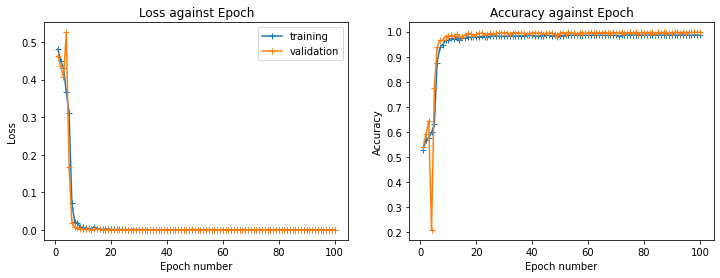

In [64]:
plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*2, plt.rcParams['figure.figsize'][1]))
gs = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs[0])
ax.plot([i for i in range(1, len(history.history["loss"])+1)], history.history["loss"], "+-", label="training")
ax.plot([i for i in range(1, len(history.history["val_loss"])+1)], history.history["val_loss"], "+-", label="validation")
ax.legend()
ax.set_xlabel("Epoch number")
ax.set_ylabel("Loss")
ax.set_title("Loss against Epoch")

ax = plt.subplot(gs[1])
ax.plot([i for i in range(1, len(history.history["accuracy"])+1)], history.history["accuracy"], "+-", label="training")
ax.plot([i for i in range(1, len(history.history["val_accuracy"])+1)], history.history["val_accuracy"], "+-", label="validation")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy against Epoch")

plt.savefig("training.pdf")
plt.show()

# Test Model

In [50]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 6.600684719160199e-05
Test accuracy: 0.9965047240257263


In [51]:
i = 6
print("True SO(3):\n", y_test[i].astype("float32"), end="\n\n", sep="")
prediction = model.predict(x_test[i].reshape((1,)+x_test[i].shape))[0]
print("SO(3) Prediction:\n", prediction, sep="")
print("Distance: {:.2f} degrees".format(SO3_distance(y_test[i], prediction)))

True SO(3):
[[ 0.2763084   0.96106905  0.        ]
 [-0.96106905  0.2763084   0.        ]
 [ 0.          0.          1.        ]]

SO(3) Prediction:
[[ 0.27592865  0.9611542  -0.00677387]
 [-0.9611719   0.2758948  -0.00552686]
 [-0.0034433   0.00803587  0.99996173]]
Distance: 0.50 degrees


# Analyse Results

In [52]:
distances = np.zeros(x_test.shape[0])
predictions = model.predict(x_test)
for i in tqdm(range(x_test.shape[0])):
  distances[i] = SO3_distance(y_test[i], predictions[i])

  0%|          | 0/4673 [00:00<?, ?it/s]

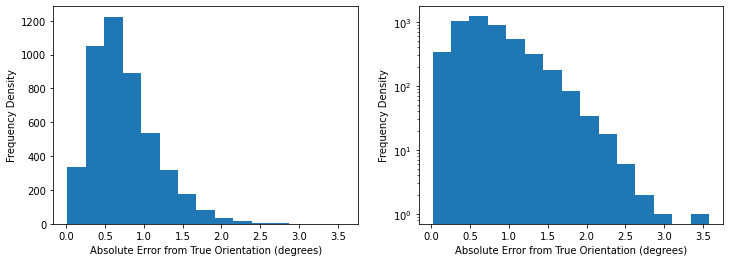

In [63]:
plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*2, plt.rcParams['figure.figsize'][1]))
gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0])
ax.hist(distances, bins=15)
ax.set_xlabel("Absolute Error from True Orientation (degrees)")
ax.set_ylabel("Frequency Density")

ax = plt.subplot(gs[1])
ax.hist(distances, bins=15, log="y")
ax.set_xlabel("Absolute Error from True Orientation (degrees)")
ax.set_ylabel("Frequency Density")

plt.savefig("error_hist.pdf")
plt.show()

In [59]:
distance_mean = np.mean(distances)
distance_std = np.std(distances, ddof=1)
print(f"Average distance from the true value is {distance_mean:.2f} +- {distance_std:.2f}")

Average distance from the true value is 0.75 +- 0.41
